In [ ]:
import pandas as pd
import numpy as np
from utils.stofn import *
from utils.eldi import *
from utils.dreifing import *
from utils.gogn import *
import random

In [ ]:
data = {}
data['rivers'] = getRivers()
data['eldi'] =  getFarms()
data['distances'] = getDistances()

In [ ]:
ITERS = 10


SAFN_VESTUR_SIZE = 0
SAFN_AUSTUR_SIZE = 0

# EVENTS_PER_YEAR = 1.75 # Average number of escape events per year ## gamla
A = 0.029
B = 0.912
EVENTS_PER_YEAR = A*np.sum(data['eldi']['Stock'].to_numpy())**B
SIZE_PROPORTION = 0.67 # Proportion of Early vs Late escapees
ESCAPES_PER_TON = 0.5 # Amount of escapees per 1000 ton

LATE_RETURNS_PROP = 0.0016 # Proportion of Late escapees that return to rivers (0.16%)
EARLY_RETURNS_PROP = 0.0007 # Proportion of Early escapees that return to rivers (0.07%)
EARLY_YEARLY_DISTR = [0, 30/56, 17/56, 9/56] # Early returns distributed over four years

LATE_PROPORTION = 0.2
LATE_LENGTH = 240

EARLY_PROPORTION = 0.5
EARLY_LENGTH = 140

In [ ]:
# Fyrir sensitivity analysis
def runSimulation(ITERS = ITERS, \
            SAFN_VESTUR_SIZE = SAFN_VESTUR_SIZE, \
            SAFN_AUSTUR_SIZE = SAFN_AUSTUR_SIZE, \
            LATE_PROPORTION = LATE_PROPORTION,\
            EARLY_PROPORTION = EARLY_PROPORTION,\
            LATE_LENGTH = LATE_LENGTH, \
            EARLY_LENGTH = EARLY_LENGTH, \
            EVENTS_PER_YEAR = EVENTS_PER_YEAR, \
            ESCAPES_PER_TON = ESCAPES_PER_TON, \
            SIZE_PROPORTION = SIZE_PROPORTION, \
            LATE_RETURNS_PROP = LATE_RETURNS_PROP, \
            EARLY_RETURNS_PROP = EARLY_RETURNS_PROP, \
            EARLY_YEARLY_DISTR = EARLY_YEARLY_DISTR):
        if SAFN_VESTUR_SIZE > 1:
            data['rivers'].loc[data['rivers']['nafn']=='Safn Vestur','logMedal10']= np.log(SAFN_VESTUR_SIZE)
            data['rivers'].loc[data['rivers']['nafn']=='Safn Vestur','expMedal10']= SAFN_VESTUR_SIZE
        if SAFN_AUSTUR_SIZE > 1:
            data['rivers'].loc[data['rivers']['nafn']=='Safn Austur','logMedal10'] = np.log(SAFN_AUSTUR_SIZE)
            data['rivers'].loc[data['rivers']['nafn']=='Safn Austur','expMedal10'] = SAFN_AUSTUR_SIZE
        stofnar = stofnstaerdir(data,ITERS)
        escSchedule = calcEscapeEvents(data,ITERS, EVENTS_PER_YEAR)
        farmEvents = splitEvents(data, escSchedule, ITERS)
        farmEventsEarly, farmEventsLate = splitFarmEvents(data, farmEvents,ITERS,SIZE_PROPORTION)
        farmNumbersEarly, farmNumbersLate = getSizeOfEvents(data,farmEventsEarly, farmEventsLate, ESCAPES_PER_TON, EVENTS_PER_YEAR)
        farmEarlyReturns, farmLateReturns = getNumberOfReturners(data, farmNumbersEarly, farmNumbersLate, ITERS, LATE_RETURNS_PROP, EARLY_RETURNS_PROP, EARLY_YEARLY_DISTR)
        results = getResults(data, stofnar, farmEarlyReturns, farmLateReturns, ITERS,LATE_PROPORTION,EARLY_PROPORTION,LATE_LENGTH,EARLY_LENGTH )

        results[0].drop(columns=['Safn Austur','Safn Vestur'],inplace=True)
        results[1].drop(columns=['Safn Austur','Safn Vestur'],inplace=True)
        return results
    

In [ ]:
# Keyrir sensitivity analysis
avg = pd.DataFrame([])
count4 = pd.DataFrame([])
count4over3 = pd.DataFrame([])

start = 180 # fyrsta gildi til að prófa
stop =  280 # síðasta gildi til að prófa
num = 10    # fjöldi gilda til að prófa
values = np.linspace(start,stop,num)
for val in values:
    print(val)
    results = runSimulation(LATE_LENGTH = val) ## Parameter to change
    avg[val] = results[0].mean(axis=0)
    count4[val] = ((results[0]>4)*1).mean(axis=0)*100
    count4over3 = ((results[1]>4)*1).mean(axis=0)*100



In [ ]:
# Vistar sensitivity analysis
avg.to_csv('data/sensAnalysis/Late_lengthavg.csv')  
count4.to_csv('data/sensAnalysis/Late_lengtho4.csv') 
count4over3.to_csv('data/sensAnalysis/Late_length4o3.csv') 

In [ ]:
# Til að fá áfrif hvers eldisstaðar á niðurstöður
def runSimulation2():
        if SAFN_VESTUR_SIZE > 1:
            data['rivers'].loc[data['rivers']['nafn']=='Safn Vestur','logMedal10']= np.log(SAFN_VESTUR_SIZE)
            data['rivers'].loc[data['rivers']['nafn']=='Safn Vestur','expMedal10']= SAFN_VESTUR_SIZE
        if SAFN_AUSTUR_SIZE > 1:
            data['rivers'].loc[data['rivers']['nafn']=='Safn Austur','logMedal10'] = np.log(SAFN_AUSTUR_SIZE)
            data['rivers'].loc[data['rivers']['nafn']=='Safn Austur','expMedal10'] = SAFN_AUSTUR_SIZE
        stofnar = stofnstaerdir(data,ITERS)
        escSchedule = calcEscapeEvents(data,ITERS, EVENTS_PER_YEAR)
        farmEvents = splitEvents(data, escSchedule, ITERS)
        farmEventsEarly, farmEventsLate = splitFarmEvents(data, farmEvents,ITERS,SIZE_PROPORTION)
        farmNumbersEarly, farmNumbersLate = getSizeOfEvents(data,farmEventsEarly, farmEventsLate, ESCAPES_PER_TON, EVENTS_PER_YEAR)
        farmEarlyReturns, farmLateReturns = getNumberOfReturners(data, farmNumbersEarly, farmNumbersLate, ITERS, LATE_RETURNS_PROP, EARLY_RETURNS_PROP, EARLY_YEARLY_DISTR)
        results = getSplitResults(data, stofnar, farmEarlyReturns, farmLateReturns, ITERS,LATE_PROPORTION,EARLY_PROPORTION,LATE_LENGTH,EARLY_LENGTH)

        return results

In [ ]:
skipting = runSimulation2()
print(skipting)
print('Hlutfall í safnár: ', (skipting.loc['Safn Austur'].sum()+skipting.loc['Safn Vestur'].sum())/skipting.sum().sum())


In [ ]:
ITERS = 1000

SAFN_VESTUR_SIZE = 0
SAFN_AUSTUR_SIZE = 0

# EVENTS_PER_YEAR = 1.75 # Average number of escape events per year ## gamla
A = 0.029
B = 0.912
EVENTS_PER_YEAR = A*np.sum(data['eldi']['Stock'].to_numpy())**B
SIZE_PROPORTION = 0.67 # Proportion of Early vs Late escapees
ESCAPES_PER_TON = 0.5 # Amount of escapees per 1000 ton

LATE_RETURNS_PROP = 0.0016 # Proportion of Late escapees that return to rivers (0.16%)
EARLY_RETURNS_PROP = 0.0007 # Proportion of Early escapees that return to rivers (0.07%)
EARLY_YEARLY_DISTR = [0, 30/56, 17/56, 9/56] # Early returns distributed over four years

LATE_PROPORTION = 0.2
LATE_LENGTH = 240

EARLY_PROPORTION = 0.5
EARLY_LENGTH = 140

In [ ]:
## Til að fá uþb meðaltalsniðurstöðu án simulation
ahrif = [np.array(0)]*12

dataCopy = data.copy()
if SAFN_VESTUR_SIZE > 1:
    dataCopy['rivers'].loc[dataCopy['rivers']['nafn']=='Safn Vestur','logMedal10']= np.log(SAFN_VESTUR_SIZE)
    dataCopy['rivers'].loc[dataCopy['rivers']['nafn']=='Safn Vestur','expMedal10']= SAFN_VESTUR_SIZE
if SAFN_AUSTUR_SIZE > 1:
    dataCopy['rivers'].loc[dataCopy['rivers']['nafn']=='Safn Austur','logMedal10'] = np.log(SAFN_AUSTUR_SIZE)
    dataCopy['rivers'].loc[dataCopy['rivers']['nafn']=='Safn Austur','expMedal10'] = SAFN_AUSTUR_SIZE
for farmNo in range(12):
    ahrif[farmNo] = ((1-SIZE_PROPORTION)*getLateFarmedDistribution(data,farmNo,LATE_PROPORTION,LATE_LENGTH)/dataCopy['rivers']['expMedal10']).values
    ahrif[farmNo] += ((SIZE_PROPORTION)*getEarlyFarmedDistribution(data,farmNo,EARLY_PROPORTION,EARLY_LENGTH)/dataCopy['rivers']['expMedal10']).values


def costFunction1(eldismagn):
        dataCopy = data.copy()
        dataCopy['eldi']['Stock'] = eldismagn
        if SAFN_VESTUR_SIZE > 1:
            dataCopy['rivers'].loc[dataCopy['rivers']['nafn']=='Safn Vestur','logMedal10']= np.log(SAFN_VESTUR_SIZE)
            dataCopy['rivers'].loc[dataCopy['rivers']['nafn']=='Safn Vestur','expMedal10']= SAFN_VESTUR_SIZE
        if SAFN_AUSTUR_SIZE > 1:
            dataCopy['rivers'].loc[dataCopy['rivers']['nafn']=='Safn Austur','logMedal10'] = np.log(SAFN_AUSTUR_SIZE)
            dataCopy['rivers'].loc[dataCopy['rivers']['nafn']=='Safn Austur','expMedal10'] = SAFN_AUSTUR_SIZE
        distribution =pd.DataFrame(0, index=[0], columns=dataCopy['rivers']['nafn'])
        for farmNo in range(12):
            distribution += eldismagn[farmNo]*ahrif[farmNo]
        distribution.drop(columns=['Safn Austur','Safn Vestur'],inplace=True)

        return distribution.max(axis = 1).values

In [ ]:
# Til að fá niðurstöður fyrir mismunandi eldismagn
def costFunction2(eldismagn):
        dataCopy = data.copy()
        dataCopy['eldi']['Stock'] = eldismagn
        if SAFN_VESTUR_SIZE > 1:
            data['rivers'].loc[data['rivers']['nafn']=='Safn Vestur','logMedal10']= np.log(SAFN_VESTUR_SIZE)
            data['rivers'].loc[data['rivers']['nafn']=='Safn Vestur','expMedal10']= SAFN_VESTUR_SIZE
        if SAFN_AUSTUR_SIZE > 1:
            data['rivers'].loc[data['rivers']['nafn']=='Safn Austur','logMedal10'] = np.log(SAFN_AUSTUR_SIZE)
            data['rivers'].loc[data['rivers']['nafn']=='Safn Austur','expMedal10'] = SAFN_AUSTUR_SIZE
        stofnar = stofnstaerdir(data,ITERS)
        EVENTS_PER_YEAR = A*np.sum(dataCopy['eldi']['Stock'].to_numpy())**B
        escSchedule = calcEscapeEvents(data,ITERS, EVENTS_PER_YEAR)
        farmEvents = splitEvents(data, escSchedule, ITERS)
        farmEventsEarly, farmEventsLate = splitFarmEvents(data, farmEvents,ITERS,SIZE_PROPORTION)
        farmNumbersEarly, farmNumbersLate = getSizeOfEvents(data,farmEventsEarly, farmEventsLate, ESCAPES_PER_TON, EVENTS_PER_YEAR)
        farmEarlyReturns, farmLateReturns = getNumberOfReturners(data, farmNumbersEarly, farmNumbersLate, ITERS, LATE_RETURNS_PROP, EARLY_RETURNS_PROP, EARLY_YEARLY_DISTR)
        results = getResults(data, stofnar, farmEarlyReturns, farmLateReturns, ITERS,LATE_PROPORTION,EARLY_PROPORTION,LATE_LENGTH,EARLY_LENGTH)
        results[0].drop(columns=['Safn Austur','Safn Vestur'],inplace=True)
        results[1].drop(columns=['Safn Austur','Safn Vestur'],inplace=True)
        return (((results[1]>4)*1).mean(axis=0)*100).max()

In [ ]:
## uþb Besta röðun

magn = np.array([0.0]*12)
diff = True
mins = [[0.0]]*300
magns = np.array([np.array([0.0]*12)]*int(144.5*2))

j = 0
while magn.sum()<144.5:
    min = 10000
    idx = 0
    for i in range(12):
        if magn[i] >= data['eldi']['max'][i]:
            continue
        magn[i] += 0.5
        res = costFunction1(magn)
        if res < min:
            idx = i
            min = res
            diff = True
        magn[i] -= 0.5
    magn[idx] =  magn[idx]+0.5
    mins[j] = min
    magns[j] = magn
    j += 1
    

In [ ]:
def binary_search(arr, x):
    low = 0
    high = len(arr) - 1
    mid = 0

    while low <= high:

        mid = (high + low) // 2

        val = costFunction2(arr[mid])
        if val < x:
            low = mid + 1

        elif val > x:
            high = mid - 1

        else:
            return mid

    return mid

In [ ]:
#besta röðun
loc = binary_search(magns, 5)
print('Besta röðun')
print('Röðun: ', magns[loc])
print('Hæsta gildi: ',costFunction2(magns[loc-1]))
print('Heildarmagn: ',magns[loc].sum())
print('Heildarmagn Vestur: ',magns[loc][0:6].sum())
print('Heildarmagn Austur: ',magns[loc][6:12].sum())


In [ ]:
# Skoðar hvernig besta röðun fæst
fig = plt.figure()
ax = plt.subplot(111)



magnsDF = pd.DataFrame(list(map(np.ravel, magns)))
magnsDF.columns = data['eldi']['Nafn']
ax.plot(magnsDF, label = magnsDF.columns)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.axvline(loc)

In [ ]:
magns

In [1]:
import numpy as np

# Given data
data1 = np.array([
    173.156, 81.074, 76.170, 68.000, 65.000, 60.528, 60.000, 54.134, 54.000, 52.743,
    51.707, 50.090, 49.626, 49.468, 48.319, 47.043, 41.904, 38.638, 36.701, 35.385,
    35.000, 30.667, 30.285, 30.000, 29.932, 26.673, 26.492, 24.800, 24.000, 23.238,
    20.000, 19.824, 18.672, 18.012, 17.200, 15.887, 14.292, 13.611, 13.535, 13.500,
    12.824, 11.510, 11.100, 10.766, 9.917, 9.352, 9.158, 8.976, 8.895, 8.830,
    8.753, 8.661, 8.504, 8.421, 8.420, 8.000, 7.303, 6.969, 6.911, 6.531,
    6.500, 6.248, 6.000, 6.000, 5.765, 5.764, 5.620, 5.248, 5.047, 5.000,
    5.000, 4.825, 4.800, 4.688, 3.741, 3.644, 3.612, 3.570, 3.500, 3.500,
    3.475, 3.174
])

# Number of bootstrap resamples
n_resamples = 100000

# Bootstrap resampling
bootstrap_means = np.random.choice(data1, size=(n_resamples, len(data1)), replace=True).mean(axis=1)

# Estimate variance of the mean
variance_of_mean = np.var(bootstrap_means, ddof=1)

print(f"Estimated variance of the mean: {variance_of_mean:.6f}")


Estimated variance of the mean: 8.182432


BootstrapResult(confidence_interval=ConfidenceInterval(low=17.927688490160996, high=29.462927884403673), bootstrap_distribution=array([28.68241463, 29.39947561, 20.65754878, 22.54041463, 24.00241463,
       25.91303659, 25.65371951, 24.203     , 25.47473171, 24.30434146,
       22.25964634, 19.54063415, 23.77435366, 21.92541463, 18.52402439,
       27.00814634, 27.56643902, 22.84076829, 22.95526829, 22.96342683,
       29.90035366, 21.90086585, 27.75452439, 20.96919512, 26.33576829,
       20.7102561 , 26.44317073, 25.09042683, 21.91987805, 24.63407317,
       17.79369512, 25.65492683, 21.7112439 , 20.1977439 , 28.56437805,
       23.1555122 , 24.27964634, 19.6057561 , 19.52815854, 27.79041463,
       22.825     , 19.94996341, 22.98604878, 20.90164634, 22.2140122 ,
       25.32190244, 23.26870732, 23.04384146, 24.72020732, 19.34480488,
       15.71992683, 23.73762195, 22.37243902, 20.15576829, 29.18912195,
       18.6025    , 29.93253659, 24.98491463, 23.54569512, 20.87213415,
       2

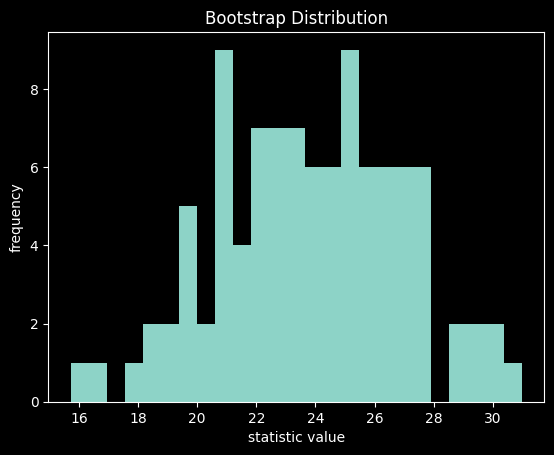

In [22]:
import matplotlib.pyplot as plt
from scipy.stats import bootstrap

data = (data1,)  # samples must be in a sequence
res = bootstrap(data, np.mean, n_resamples=100,confidence_level=0.95)
print(res)
fig, ax = plt.subplots()
ax.hist(res.bootstrap_distribution, bins=25)
ax.set_title('Bootstrap Distribution')
ax.set_xlabel('statistic value')
ax.set_ylabel('frequency')
plt.show()

In [21]:
print('Meðaltal: ',res.bootstrap_distribution.mean())
print('Stddev:' ,res.standard_error)
print('95% öryggi: ',res.confidence_interval)

Meðaltal:  23.4353216902439
Stddev: 2.843646895816467
95% öryggi:  ConfidenceInterval(low=18.8806768438082, high=30.418625866918557)
